In [29]:
import requests
from bs4 import BeautifulSoup
import time
import csv
import re
import sqlite3
import os

In [33]:
# headers = ({'User-Agent':
#             'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
#             'Accept-Language': 'en-US, en;q=0.5'})
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0", 
           "Accept-Encoding":"gzip, deflate", 
           "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", 
           "DNT":"1","Connection":"close", 
           "Upgrade-Insecure-Requests":"1"}
main_page_urls = ["https://www.amazon.com/Beyond-Meat-Beef-16-Ounce/dp/B07R6TRHQ2/"]

In [34]:
def scrape_reviews(main_page_url, headers):
    main_page = requests.get(main_page_url, headers=headers)
    main_page_soup = BeautifulSoup(main_page.content, 'html.parser')
    time.sleep(2)

    data = []
    product_name = main_page_soup.find('span', {'id': 'productTitle'}).get_text().strip()
    brand_name = main_page_soup.find('a', {'id': 'bylineInfo'}).get_text().strip()[7:]
    price = main_page_soup.find('span', {'class': 'priceBlockBuyingPriceString'}).get_text().strip()[1:]
    asin = main_page_soup.find('ul', {'class': 'detail-bullet-list'}).findAll('li')[4].findAll('span')[2].get_text()
    overall_rating = main_page_soup.find('span', {'data-hook': 'rating-out-of-text'}).get_text()[:3]
    
    review_url_base = main_page_url[:-1].replace("dp", "product-reviews") + "?ie=UTF8&reviewerType=all_reviews&sortBy=recent&pageNumber="
    review_urls = [review_url_base + str(i) for i in range(1, 10)]
    
    for review_url in review_urls:
        review_page = requests.get(review_url, headers=headers)
        review_page_soup = BeautifulSoup(review_page.content, 'html.parser')
        time.sleep(2)
        username = review_page_soup.findAll('span', {'class': 'a-profile-name'})
        date = review_page_soup.findAll('span', {'data-hook': 'review-date'})
        rating = review_page_soup.find_all('i', {'data-hook': 'review-star-rating'})
        review = review_page_soup.find_all('span', {'data-hook': 'review-body'})
        
        for i in range(2, 8):
            try:
                reviewer_username = username[i].get_text()
                review_date = date[i].get_text()[33:]
                review_rating = rating[i].span.get_text()[:3]
                review_text = review[i].get_text()[:-9].strip()

                data.append([brand_name, product_name, asin, price, overall_rating, reviewer_username, review_date, review_rating, review_text])
                
            except:
                continue
    return data

In [35]:
def write_to_db(data):
    conn = sqlite3.connect("reviewdb.db")
    c = conn.cursor()
    c.execute("""CREATE TABLE IF NOT EXISTS scraped_reviews ('brand_name', 'product_name', 'asin', 'price', 'overall_rating', 'reviewer_username', 'review_date', 'review_rating', 'review_text')""")
    
    for entry in data:
        c.execute("INSERT INTO scraped_reviews ('brand_name', 'product_name', 'asin', 'price', 'overall_rating', 'reviewer_username', 'review_date', 'review_rating', 'review_text') VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)", 
                  (entry[0], entry[1], entry[2], entry[3], entry[4], entry[5], entry[6], entry[7], entry[8]))
        
    conn.commit()
    conn.close()

<!DOCTYPE html>
<html class="a-no-js" data-19ax5a9jf="dingo" lang="en-us">
 <!-- sp:feature:head-start -->
 <head>
  <script>
   var aPageStart = (new Date()).getTime();
  </script>
  <meta charset="utf-8"/>
  <script type="text/javascript">
   var ue_t0=ue_t0||+new Date();
  </script>
  <!-- sp:feature:cs-optimization -->
  <meta content="on" http-equiv="x-dns-prefetch-control"/>
  <link href="https://images-na.ssl-images-amazon.com" rel="dns-prefetch"/>
  <link href="https://m.media-amazon.com" rel="dns-prefetch"/>
  <link href="https://completion.amazon.com" rel="dns-prefetch"/>
  <script type="text/javascript">
   window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {

var ue_csm = window,
    ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.d(),d.ue_id])};b[a].replay=function
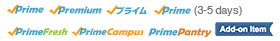

IndexError: list index out of range

In [36]:
for main_page_url in main_page_urls:
    data = scrape_reviews(main_page_url, headers)
    write_to_db(data)

In [151]:
conn = sqlite3.connect("reviewdb.db")
c = conn.cursor()
c.execute("SELECT * FROM reviews")
output = c.fetchall()
conn.close()
print(output)

[('Beyond Meat', 'Beyond Meat Beyond Burger Plant-Based Patties 2 pk, 8 oz', 'B074K5MDLW', '5.99', '4.7', 'Leon Forte', 'June 19, 2021', '5.0', 'Looks, Tastes, and Cooks Exactly Like the Real Thing, but Better.  No one can tell the difference.  No funny smell or aftertaste.  No animal cruelty or by-products.  No soy.  No gluten. No dairy.  Tons of pea protein.  Tons of flavor.  I highly recommend this product and their link sausages.'), ('Beyond Meat', 'Beyond Meat Beyond Burger Plant-Based Patties 2 pk, 8 oz', 'B074K5MDLW', '5.99', '4.7', 'Roscoe', 'June 15, 2021', '4.0', 'I was so delighted with the taste, it did not need adding any spicy or salt to give it a better taste. I wish it was more affordable: $3 for one 1/4 lb patty (while frozen) is a bit pricy?'), ('Beyond Meat', 'Beyond Meat Beyond Burger Plant-Based Patties 2 pk, 8 oz', 'B074K5MDLW', '5.99', '4.7', 'Disneymom2', 'June 15, 2021', '3.0', 'Was really gunning for these cuz I was told by so many that it taste just like norm